# _MethylBERT_ fine-tuning

Once the pure cell-type data is preprocessed following the [previous tutorial](https://github.com/hanyangii/methylbert/blob/main/tutorials/02_Preprocessing_training_data.ipynb), you can fine-tune the pre-trained MethylBERT model. 

In [1]:
from methylbert.utils import set_seed
import warnings
warnings.filterwarnings("ignore") # Ignore warnings for a clear notebook

set_seed(42)
seq_len=150
n_mers=3
batch_size=5
num_workers=20
output_path = "tmp/fine_tune/"

### Load training and evaluation data

The preprocessed data must be loaded into the `MethylBertFinetuneDataset` and the [pytorch DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) object. 

You can change the number of workers and the batch size depending on the CPU/GPU resources you have.
Please find more detailed explanation [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

In [2]:
from torch.utils.data import DataLoader
from methylbert.data.vocab import MethylVocab
from methylbert.data.dataset import MethylBertFinetuneDataset

# Creat a look-up table
tokenizer = MethylVocab(n_mers)

# Load the data files int a data set object
train_dataset = MethylBertFinetuneDataset("tmp/train_seq.csv", 
                                          tokenizer, 
                                          seq_len=seq_len)
test_dataset = MethylBertFinetuneDataset("tmp/test_seq.csv", 
                                         tokenizer,seq_len=seq_len) 

# Load the data into a data loader
train_data_loader = DataLoader(train_dataset, batch_size= batch_size, 
                               num_workers= num_workers, pin_memory=False,  
                               shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size= batch_size, 
                              num_workers= num_workers, pin_memory=True,  
                              shuffle=False)


Building Vocab
Total number of sequences :  3052
# of reads in each label:  [1561. 1491.]
Total number of sequences :  763
# of reads in each label:  [383. 380.]


### Create _MethylBERT_ model

`MethylBERT FinetuneTrainer` gets the `DataLoader` objects and hyperparameters for the training as input. 


In [7]:
from methylbert.trainer import MethylBertFinetuneTrainer
import os

trainer = MethylBertFinetuneTrainer(len(tokenizer), 
                      save_path=output_path, 
                      train_dataloader=train_data_loader, 
                      test_dataloader=test_data_loader,
                      lr=1e-4, with_cuda=False, 
                      log_freq=1,
                      #eval_freq=10, #activate this only when you want to evaluate the model with test_data_loader
                      warmup_step=3)

The model is loaded on CPU


#### Load pre-training model from the uploaded models (huggingface.co/hanyangii/)

Pre-trained models with 2, 4, 6, 8, and 12 encoder blocks are available for MethylBERT. 
You can give an argument "hanyangii/methylbert_hg19_{number of encoder blocks}l" to the `load` function. 

In [12]:
trainer.load("hanyangii/methylbert_hg19_4l")

Restore the pretrained model hanyangii/methylbert_hg19_4l


config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/120M [00:00<?, ?B/s]

Some weights of MethylBertEmbeddedDMR were not initialized from the model checkpoint at hanyangii/methylbert_hg19_4l and are newly initialized: ['dmr_encoder.0.weight', 'read_classifier.0.bias', 'read_classifier.0.weight', 'read_classifier.3.bias', 'read_classifier.3.weight', 'read_classifier.4.bias', 'read_classifier.4.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total Parameters: 46929874


#### Load pre-training model from a local directory

If you have the pre-trained model saved in a directory containing `config.json` and `pytorch_model.bin` files

In [8]:
ls ../test/data/pretrained_model/

config.json@  pytorch_model.bin@


You can directly load the model using `load` function to `MethylBertFinetuneTrainer`. 

In [9]:
trainer.load("../test/data/pretrained_model/")

Restore the pretrained model ../test/data/pretrained_model/
Total Parameters: 32754130


#### Train the _MethylBERT_ model without pre-training
If you do not have a pre-trained _MethylBERT_ model, you can create a new _MethylBERT_ model from a configuration file. 
For example, the baseline BERT model config file can be downlaoded from from https://huggingface.co/bert-base-uncased/blob/main/config.json.

In [6]:
cat ../test/data/config.json

{
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.6.0.dev0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}


Then `create_model` function of the trainer creates a new _MethylBERT_ from the config file.

In [7]:
trainer.create_model(config_file="../test/data/pretrained_model/config.json")


Total Parameters: 32754130


`train` function starts the training of _MethylBERT_ model during the given number of steps. 

In [8]:
trainer.train(steps=10)


Train Step 0 iter - loss : 0.802449 / lr : 0.000033
Running time for iter = 0.6947791576385498
Step 0 loss (0.695615) is lower than the current min loss (inf). Save the model at tmp/fine_tune/
Step:0 Model Saved on: tmp/fine_tune/



Train Step 1 iter - loss : 0.823174 / lr : 0.000067
Running time for iter = 0.621410608291626



Train Step 2 iter - loss : 1.258267 / lr : 0.000100
Running time for iter = 0.5103580951690674



Train Step 3 iter - loss : 0.490022 / lr : 0.000100
Running time for iter = 0.5122716426849365



Train Step 4 iter - loss : 1.356685 / lr : 0.000100
Running time for iter = 0.5860369205474854



Train Step 5 iter - loss : 0.959048 / lr : 0.000100
Running time for iter = 0.6873147487640381



Train Step 6 iter - loss : 0.939311 / lr : 0.000100
Running time for iter = 0.4517858028411865



Train Step 7 iter - loss : 0.776077 / lr : 0.000100
Running time for iter = 0.6021583080291748
Step 7 loss (0.691268) is lower than the current min loss (0.695615). Save the model at tmp/fine_tune/
Step:7 Model Saved on: tmp/fine_tune/



Train Step 8 iter - loss : 0.657497 / lr : 0.000100
Running time for iter = 0.4712505340576172
Step 8 loss (0.685933) is lower than the current min loss (0.691268). Save the model at tmp/fine_tune/
Step:8 Model Saved on: tmp/fine_tune/



Train Step 9 iter - loss : 0.690212 / lr : 0.000100
Running time for iter = 0.4791133403778076


It creates six files in the given `save_path`:
1. `config.json` and `pytorch_model.bin`: model configuration and the trained `MethylBERT` model
2. `dmr_encoder.pickle` : The trained DMR encoder in the _MethylBERT_ model
3. `read_classification_model.pickle` : The trained fully connected neural network for read classification
4. `train.csv` and `eval.csv` : tracked training and evaluation loss and accuracy values during the training

In [9]:
ls tmp/fine_tune/

config.json         eval.csv           read_classification_model.pickle
dmr_encoder.pickle  pytorch_model.bin  train.csv


In [10]:
import pandas as pd
df_train  = pd.read_csv("tmp/fine_tune/train.csv", sep="\t")
df_train.head()

,step,loss,ctype_acc,lr
0,0,0.802449,0.2,0.000033
1,1,0.823174,0.0,0.000067
2,2,1.258267,0.2,0.000100
3,3,0.490022,0.8,0.000100
4,4,1.356685,0.2,0.000100


In [11]:
df_eval  = pd.read_csv("tmp/fine_tune/eval.csv", sep="\t")
df_eval.head()

,step,loss,ctype_acc
0,0,0.695615,0.522936
1,1,0.876368,0.501966
2,2,0.932430,0.501966
3,3,0.942029,0.501966
4,4,0.849511,0.501966


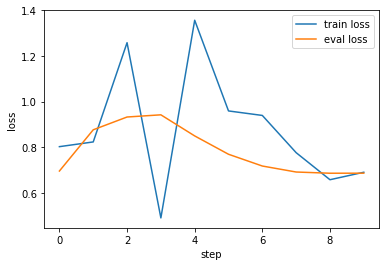

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.lineplot(data=df_train, x="step", y="loss", label="train loss")
sns.lineplot(data=df_eval, x="step", y="loss", label="eval loss")
plt.show()

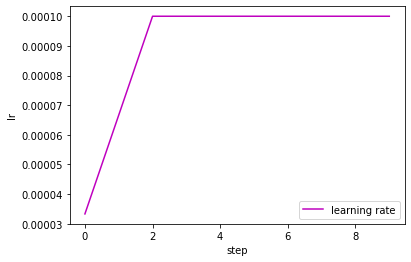

In [15]:
sns.lineplot(data=df_train, x="step", y="lr", label="learning rate", color="m")
plt.show()